In [1]:
import numpy as np
import pandas as pd
import subprocess
import time
import holidays

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rcParams 
from tqdm import tqdm
from datetime import datetime, date
from IPython.display import IFrame
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
#========================   PATHS   ========================#
DF_PATH= 'data/train.csv'
MASK_PATH= 'https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png'
CNG_PATH= 'img/congestion_table.png' #congestion table
SAF_PATH= 'img/seasonalAdjFac.png' #seasonality adjustment factor

# Problem Statement


#### Description

The goal of our project is to estimate the price of New York Taxi fare. We are given a training data set of 55 million rows. We will create various models that attempt to estimate the target variable, and the metric we will use to evaluate the quality of our model will be the root mean square error:

\begin{equation*}
\sqrt{ \frac{1}{n} \sum_{i=1}^n \hat (y_i - y_i)^2 }
\end{equation*}


#### Features:

    pickup_datetime - timestamp value indicating when the taxi ride started.
    pickup_longitude - float for longitude coordinate of where the taxi ride started.
    pickup_latitude - float for latitude coordinate of where the taxi ride started.
    dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
    dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
    passenger_count - integer indicating the number of passengers in the taxi ride.

#### Target: 

    fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

#### How are Taxi Fares actually calculated?

Before we start, we will first look at what exactly the taxi fare is constituted of. There are various charges that are both fixed and variable that play into the final price of a taxi. While it is not crucial that we try to model all of these charges (nor do we have all the datapoints to be able to do so) it does help our understanding of the fare prices.

- \\$2.50 initial charge for any ride
- \\$0.50 per 1/5 mile when traveling above 12 mph *OR* per 60 seconds in slow traffic or when vehicle has stopped
- \\$0.50 MTA State Surcharge for all trips that end in  New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties
- \\$0.30 Improvement surcharge
- \\$0.50 overnight surcharge from 8 pm to 6 am
- \\$1.00 rush hour surcharge from 4 pm to 8 pm on weekdays, excluding holidays
- \\$2.50 (Yellow Cab) or \\$2.75 Congestion Surcharge for all trips that begin, end or pass through Manhattan south of 96th street
    
We will keep these in mind while we analyze the data


# Load Datasets

The dataset contains over 55,423,856 rows and 7 columns, making it hard to manipulate. The following solution parts the dataset into chunks that are afterwards concatenated. Also, it includes a faster way to read date type values, than the pre-defined parse_date parameter of read_csv.
Source: [kaggle](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows)

In [2]:
%%time

df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000 # 5m rows chunks

# Columns to keep and input for dtype
dftypes = {'fare_amount': np.float32,
              'pickup_datetime': str, 
              'pickup_longitude': np.float32,
              'pickup_latitude': np.float32,
              'dropoff_longitude': np.float32,
              'dropoff_latitude': np.float32,
              'passenger_count': int}


for df_chunk in tqdm(pd.read_csv(DF_PATH,
                                 nrows= 5_000_000,
                                 usecols= list(dftypes.keys()),
                                 dtype= dftypes,
                                 chunksize= chunksize)):
     
    # Faster than using parse_dates
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str[0: 13]
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'],
                                                 utc=True, 
                                                 format='%Y/%m/%d %H')
    df_list.append(df_chunk) 

        
# Merge all dataframes into one dataframe
df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list



1it [00:13, 13.79s/it]

CPU times: user 14.5 s, sys: 886 ms, total: 15.4 s
Wall time: 13.9 s


In [3]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:00:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:00:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:00:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:00:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:00:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


## Data Cleaning
#### Remove duplicates

In [4]:
print(f"From {df.shape[0]} rows,")
df.drop_duplicates(inplace=True)
print(f"to {df.shape[0]} rows")

From 5000000 rows,
to 4998527 rows


#### Remove Null values

In [5]:
#check for missing values
print(f"Missing values in the datset: \n{df.isnull().sum().sort_values(ascending=False)}\n")

#drop the missing values
indexes = list(df.loc[df.isnull().any(1)].index)
df.drop(index= indexes, inplace= True)

Missing values in the datset: 
dropoff_latitude     36
dropoff_longitude    36
passenger_count       0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
fare_amount           0
dtype: int64



#### Variable Fares 

There are fares with negative or zero values. Also, there is a number of extremely high fare amount values. The corresponding rows are removed.

count    4.998148e+06
mean     1.132243e+01
std      9.774469e+00
min      1.000000e-02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

Rows with negative/ zero values: 0


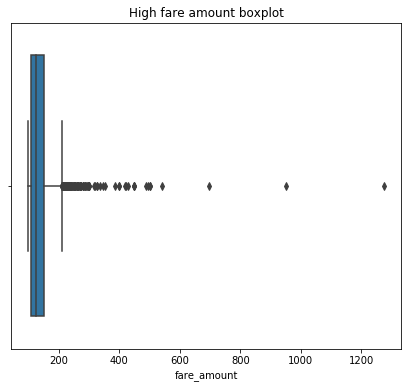

In [15]:
# Description
print(df['fare_amount'].describe())

bad_values= df.loc[df['fare_amount']<=0].index
print(f"\nRows with negative/ zero values: {len(bad_values)}")
 
# Remove positive extreme outliers
f, ax = plt.subplots(figsize=(7, 6))
ax.set_title("High fare amount boxplot")
sns.boxplot(x=df['fare_amount'][df["fare_amount"]>100])
bad_values.append(df.loc[df['fare_amount']>200].index)

# Remove rows
df.drop(bad_values, axis=0, inplace=True)

#### Variable Passengers 

On the dataset, there are rides with zero or negative passengers. Also, there are rides with an excessive amount of passengers. The corresponding rows are removed.

In [7]:
print("\nPassengers in the dataset:", df['passenger_count'].describe())

# Position of rows
bad_values= list(df.loc[df['passenger_count']>12].index) + \
            list(df.loc[df['passenger_count']<=0].index)

# Deletion
df.drop(index= bad_values, inplace=True)


Passengers in the dataset: count    4.998148e+06
mean     1.684875e+00
std      1.331980e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64


#### Date Variable

In [8]:
print(f"Earliest date: {df['pickup_datetime'].min()}")
print(f"Latest date: {df['pickup_datetime'].max()}")
print(f"Time Span: {df['pickup_datetime'].max() -df['pickup_datetime'].min()}")

Earliest date: 2009-01-01 00:00:00+00:00
Latest date: 2015-06-30 23:00:00+00:00
Time Span: 2371 days 23:00:00


#### Spatial Variables
   Initially, the bounds of the NYC are set, as they were drawn on the map of [boundingbox](https://boundingbox.klokantech.com/). Then, the dataset is filtered. 

In [9]:
# Boundaries of the metropolitan area
Boundaries = (-74.3, -73.6, 40.5, 41)
long_lim = list(Boundaries[0:2])
lat_lim = list(Boundaries[2:4])


# NYC Coordinates
nyc = (40.7141667, -74.0063889)
# Airports Coordinates
jfk= (40.6441666667, -73.7822222222)
lgd= (40.7769271, -73.87396590000003)



# Remove rides outside the metropolitan area
# Longitude
df = df[(df.pickup_longitude> long_lim[0]) & (df.pickup_longitude < long_lim[1])]
df = df[(df.dropoff_longitude> long_lim[0]) & (df.dropoff_longitude < long_lim[1])]
# Latitude
df = df[(df.pickup_latitude> lat_lim[0]) & (df.pickup_latitude < lat_lim[1])]
df = df[(df.dropoff_latitude> lat_lim[0]) & (df.dropoff_latitude < lat_lim[1])]

#### Mask datapoints in the water

A number of points are located on coordinates that correspond to sea or rivers. These datapoints are detected, with a mask from a map of the area, and are deleted. Initially, the mask is transformed in order to only contain 0 and 1 values. Then, the coordinates are transformed to the local X~Y system and the mask is applied to eliminate fault datapoints.

In [10]:
# Load mask
mask = plt.imread(MASK_PATH)[:,:,0] #y first, x second

# Need to make it boolean in order to use it as mask
print("Unique values before:\n\n",np.unique(mask))

mask = mask>0.5
print("\nUnique values after:\n\n",np.unique(mask))

Unique values before:

 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.02745098
 0.03529412 0.05490196 0.05882353 0.06666667 0.07450981 0.08235294
 0.08627451 0.09019608 0.09803922 0.12156863 0.12941177 0.14509805
 0.14901961 0.16470589 0.16862746 0.22745098 0.23921569 0.26666668
 0.27058825 0.32941177 0.33333334 0.34117648 0.37254903 0.3882353
 0.4117647  0.41568628 0.48235294 0.52156866 0.54509807 0.58431375
 0.59607846 0.627451   0.6666667  0.68235296 0.70980394 0.7137255
 0.72156864 0.73333335 0.7411765  0.7764706  0.7882353  0.8235294
 0.827451   0.85490197 0.8627451  0.88235295 0.8862745  0.9019608
 0.92156863 0.92941177 0.9411765  0.9529412  0.9607843  0.9764706
 0.98039216 1.        ]

Unique values after:

 [False  True]


In [11]:
def to_XY (longitude, latitude, mask, Boundaries):
    minLongitude = Boundaries[0]
    minLatitude = Boundaries[2]
    
    length = Boundaries[1] - minLongitude
    width = Boundaries[3] - minLatitude
    
    mask_length = mask.shape[1]
    mask_width = mask.shape[0]
    
    x = mask_length * (longitude - minLongitude) / length
    y = mask_width * (1 - (latitude - minLatitude) / width ) #imread reads from +y to -y

    
    return x.astype("int") ,y.astype("int")

#===================================================================================

# Application

pickupX, pickupY = to_XY(longitude= df.pickup_longitude, 
                         latitude= df.pickup_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

dropoffX, dropoffY = to_XY(longitude= df.dropoff_longitude, 
                         latitude= df.dropoff_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

# Multiply X,Ys with the mask
# Bitwise addition to concatenate all points into one array
idx = mask[pickupY, pickupX] & mask[dropoffY, dropoffX]
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 52071


In [12]:
print(f"From {df.shape[0]} rows,")

# Keep only points in land
df = df[idx]

print(f"to {df.shape[0]} rows.")

From 4872759 rows,
to 4820688 rows.


# New Features

## Within Manhattan Column

In [13]:
# Source: https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python 

import matplotlib.path as mpltPath
manhattan_path = mpltPath.Path([[40.698,-74.019 ],[40.757,-74.014 ],
                                [ 40.881745, -73.934875 ],[ 40.872186, -73.909654 ],
                                [40.834051, -73.934120],[ 40.809238, -73.933307 ],
                                [40.798337, -73.927591],[ 40.773668, -73.941674 ],
                                [40.741346, -73.966607],[40.707832, -73.974694]])


def is_within(lon,lat,path):  #(Latitude, Longitude, Boundaries)
    return path.contains_point([lon,lat])

df['manhattan'] = np.vectorize(is_within)(df['pickup_latitude'], #transform function to being numpy-aware
                                                      df['pickup_longitude'],
                                                      manhattan_path) & \
                    np.vectorize(is_within)(df['dropoff_latitude'],
                                                      df['dropoff_longitude'],
                                                      manhattan_path)

# Percentage of rides copletely within Manhattan
print ('{:.3}% of the sample rides are wholly within Manhattan'\
       .format(df[df.manhattan].shape[0] / df.shape[0] * 100))

86.3% of the sample rides are wholly within Manhattan


## Distance to Airport Coordinates

Another important factor in price is whether the ride was called from an airport or not. Airport pickups and dropoffs have a fixed price, which can affect greatly the fare price. We want to make sure that these rides are treated separately from regular rides.

Flat Taxi Fares from Airport to Manhattan:
- LaGuardia: Standard metered fare
- From JFK to Manhattan: \\$52 (2015)
- Newark Airport: \\$17.50 Surcharge + Toll fee


In [14]:
# Airport Coordinates

jfk_coordinates = (40.639722, -73.778889) # JFK: John F. Kennedy International Airport
ewr_coordinates = (40.6925, -74.168611)  # EWR: Newark Liberty International Airport
lga_coordinates = (40.77725, -73.872611) # LGA: LaGuardia Airport

def get_haversine_dist(start_lat, start_lon, finish_lat, finish_lon):

    r = 3956 # radius of earth in miles
    # convert latitude/longitude degrees to radians
    start_lat, start_lon, finish_lat, finish_lon = map(np.radians,
                                                             [start_lat, start_lon, 
                                                              finish_lat, finish_lon])
    #Compute distances along lat, lon dimensions
    dlat = finish_lat - start_lat
    dlon = finish_lon - start_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(start_lat) * np.cos(finish_lat) * np.sin(dlon/2.0)**2
    
    return 2 * r * np.arcsin(np.sqrt(a))

# Add distance distance calculations to the training dataset

df['distance_of_ride'] = get_haversine_dist(df['pickup_latitude'], df['pickup_longitude'], 
                                   df['dropoff_latitude'] , df['dropoff_longitude'])
df['distance_pickup_jfk'] =  get_haversine_dist(df['pickup_latitude'], df['pickup_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 
df['distance_dropoff_jfk'] =  get_haversine_dist(df['dropoff_latitude'], df['dropoff_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 

df['distance_pickup_ewr'] =  get_haversine_dist(df['pickup_latitude'], df['pickup_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 
df['distance_dropoff_ewr'] =  get_haversine_dist(df['dropoff_latitude'], df['dropoff_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 

df['distance_pickup_lga'] =  get_haversine_dist(df['pickup_latitude'], df['pickup_longitude'], lga_coordinates[0], lga_coordinates[1]) 
df['distance_dropoff_lga'] =  get_haversine_dist(df['dropoff_latitude'], df['dropoff_longitude'], lga_coordinates[0], lga_coordinates[1])


#### Clean Data based on distance

It appears that for many rows, the pickup point is the same as the dropoff point, while there is a fare charged and a number of passengers. We assume it corresponds to rides charging the waiting time for the taxi without an actual route. Therefore, the subset is extracted from the original dataset and retained.

In [15]:
wait = df.loc[df.distance_of_ride==0]
df = df.loc[df.distance_of_ride!=0]

## Airport Ride Boolean

In [16]:
# Columns that indicate whether a ride is from one of the airports
df['airport_ride_type'] = None
df.loc[(df['distance_pickup_jfk'] < 1.5) | (df['distance_dropoff_jfk'] < 1.5), 'airport_ride_type']= 'JFK'
df.loc[(df['distance_pickup_ewr'] < 1.5) | (df['distance_dropoff_ewr'] < 1.5), 'airport_ride_type']= 'EWR'
df.loc[(df['distance_pickup_lga'] < 1.5) | (df['distance_dropoff_lga'] < 1.5), 'airport_ride_type']= 'LGA'

In [17]:
# See how many rides from each of the airport types
summary = df.groupby(['airport_ride_type']).agg({'fare_amount': len}).rename(columns={'fare_amount': 'count_of_rows'})

print('The number of rides that were dropped off from: ')
print('JFK: {num}'.format(num= summary.loc['JFK','count_of_rows']))
print('EWR: {num}'.format(num=summary.loc['EWR','count_of_rows']))
print('NGA: {num}'.format(num=summary.loc['LGA','count_of_rows']))

The number of rides that were dropped off from: 
JFK: 91770.0
EWR: 6511.0
NGA: 158118.0


## Congestion Column
In order to incorporate external information on traffic patterns, we created a new column containing a traffic congestion factor for every given datetime. It takes into consideration daily fluctuation of traffic congestion, as well as seasonal and year fluctuation.
Sources:
         [Traffic Congestion Statistics](https://www.tomtom.com/en_gb/trafficindex/city/new-york) \
         [Seasonal Adjustment Factors](https://www.dot.ny.gov/divisions/engineering/technical-services/hds-respository/Tab/NYSDOT_2017_Seasonal_Adjustment_Factors.pdf)

In [18]:
# Get National Holidays
all_hols = []
for year in range(2008, 2019):
    for date, name in sorted(holidays.US(state='NY', years=year).items()):
        all_hols.append(date)

# Seasonality
# Jan=0,...Dec=11
urban = [0.879,0.905,0.966,1.016,1.052,1.069,1.047,1.054,1.039,1.033,0.976,0.964]
suburban = [0.782,0.804,0.868,0.948,1.076,1.132,1.230,1.224,1.097,1.035,0.927,0.876]
# Yearly
cong_yearly = {2009: 1.25, 2010: 1.26, 2011: 1.25, 2012: 1.22, 2013: 1.25, 2014: 1.31, 2015: 1.34, 2016: 1.38}
# Weekdays
# Monday=0,...Sunday=6
cong_morning = {0: 1.47, 1: 1.52, 2: 1.49, 3: 1.50, 4: 1.43}
cong_evening = {0: 1.53, 1: 1.59, 2: 1.61, 3: 1.63, 4: 1.65}

# Highway - Non-Highway ratio
H_ratio = 3_435 / 98_091
nH_ratio = 1 - H_ratio

def calc_congestion(pickup_date: datetime.timestamp, holiday_dates: list) -> float:        
    
    '''
    To use the seasonality table, we need to estimate the factor group. This is done with the information
    from the congestion table. The ratio of highways to no-highways is used as an indication of the urban
    and suburban factors for the dataset. 
    
    We derive separate factors from each part of the tables. The overall factor is then calculated as the
    product of those individual factors.
    
    1. Seasonal Adjustment Factor.
        
        Seasonality:
        H_ratio * suburban + nH_ratio * urban
    
    2. Traffic Congestion Statistics.
    
        Congestion Level:
        cong_yearly
    
        Morning Peak       #Mon-Fri (5:00 to 10:00):
        cong_morning
    
        Evening Peak       #Mon_Fri (16:00 to 20:00):
        cong_evening
    
    The congestion is given as an overall percentage to be associated with each pickup_datetime.
    '''

    year = pickup_date.year
    month = pickup_date.month - 1
    weekday = pickup_date.weekday()
    date = pickup_date.date()
    hour = pickup_date.hour

    # The seasonal factor is derived as a ratio between urban and suburban
    seasonal_factor = H_ratio * urban[month] + nH_ratio * suburban[month]

    # The year factor is assigned staright from the year dictionary
    if year in cong_yearly:
        year_factor = cong_yearly[year]
    
    day_factor = 1.
    # The daily factor checks for being a workday and not a holiday. Then the rush hour is checked 
    if weekday in range(5) and date not in all_hols:        
        if hour>=5 and hour<=10: #morning peak
            day_factor = cong_morning[weekday]
        elif hour>=16 and hour<=20: #evening peak
            day_factor = cong_evening[weekday]
        
            
    return year_factor * seasonal_factor * day_factor



# Create the new column
df = df.assign( congestion= df.pickup_datetime.apply(lambda x: calc_congestion(x, all_hols)))

## Pickup Date Breakdown

We also created columns that picked apart the pick_up_datetime into its various time components

In [ ]:
# Breakdown of pick up datetime to its time components 

df['hour'] = df.pickup_datetime.dt.hour
df['month'] = df.pickup_datetime.dt.month
df['year'] = df.pickup_datetime.dt.year
df['weekday'] = df.pickup_datetime.dt.weekday

# Fare per mile 
df['fare_per_mile'] = df.fare_amount / df.distance_of_ride
df.loc[df['fare_per_mile'] == np.inf,'fare_per_mile'] = 0

# Exploratory Data Analysis

## Summarize Variables

Below we created a chart with various summary statistics about each column. This allows us to get a quick sense of the kind of data. 

In [ ]:
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization

summary = df.describe().transpose().reset_index().rename(columns = {"index" : 
                                                                          "variable"})
summary  = np.around(summary,2)

var_lst = [summary["variable"],summary["count"],summary['mean'],summary['std'],
           summary["min"],summary["25%"],summary["50%"],summary["75%"],summary["max"]]

table = go.Table(header = dict(values = summary.columns.tolist(),
                               line = dict(color = ['#506784']),
                               fill = dict(color = ['#F7DC6F']),
                              ),
                 cells  = dict(values = var_lst,
                               line = dict(color = ['#506784']),
                               fill = dict(color = ["#F7DC6F",'#EBF5FB']),
                              ),
                 columnwidth = [130,80,80,80,80,80,80,80,80])
                
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[table],layout=layout)
py.iplot(figure)

## Visualise datapoints
The sample from the dataset the spatial points are plotted. The magnitude of the points is sufficient to view an abstract mapping of the metropolitan area. Also, it is interesting to see that the vast majority of the geospatial points are located in Manhattan

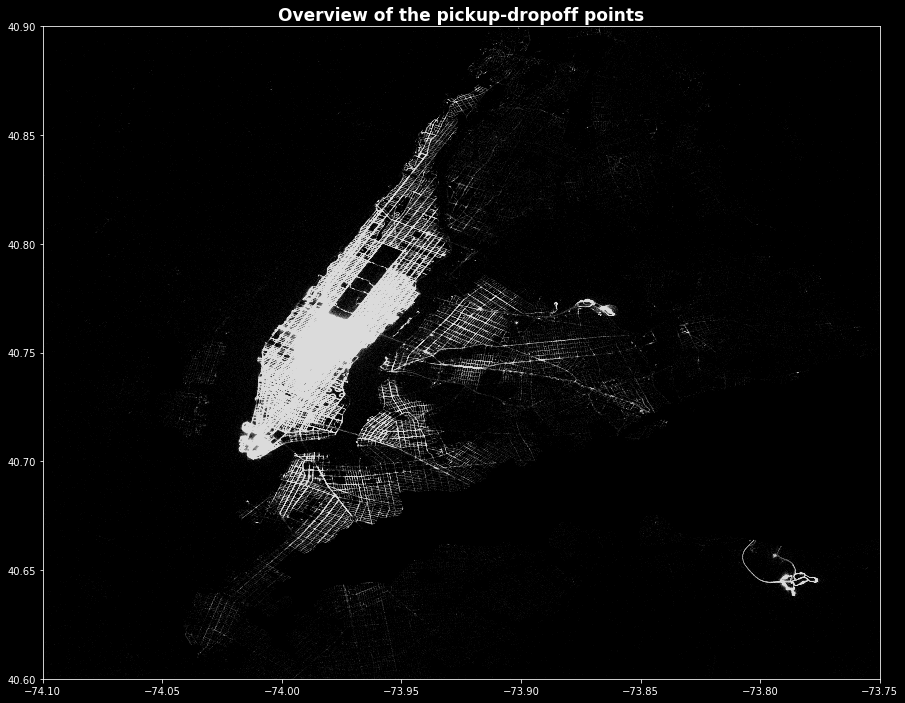

CPU times: user 7.92 s, sys: 1.79 s, total: 9.71 s
Wall time: 7.64 s


In [ ]:
%%time
%matplotlib inline

# Plot pickups, dropoffs
plot_df= df

a1 = list(plot_df.pickup_longitude)
a2 = list(plot_df.pickup_latitude)

b1 = list(plot_df.dropoff_longitude)
b2 = list(plot_df.dropoff_latitude)

# Plot 

plt.style.use('dark_background')
plt.figure(figsize = (15,12))

plt.plot( a1, a2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.plot( b1, b2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.title(label= "Overview of the pickup-dropoff points", fontdict= {'weight' : 'bold', 'size'   : 17})

plt.xlim((-74.1, -73.75))
plt.ylim((40.6, 40.9))
plt.show()

## Relationships between Variables

#### All Histograms

In [1]:
#### Histograms for Distance Attributes
fig, axes = plt.subplots(1,1,figsize=(8, 8))
ax= sns.distplot(np.array(df['fare_amount']), rug=False)
ax.set_title('Fare Amount Distribution')

NameError: name 'plt' is not defined

When looking at the distribution of fare amount in the data, we see quite a lot of outliers, so we filtered fare amount to only those that were less than 100 to get a sense of the distribution. The mean fare amount is 11.17 with a standard deviation of 9.3. We see that the distribution of fare amounts is skewed to the right.

#### Count of datapoints through time

In [ ]:
df['pickup_date'] = df['pickup_datetime'].map(lambda x: str(x.year)+'-'+ "%02d" % (x.month))
year_count_df = df.groupby('pickup_datetime', as_index=False).count()

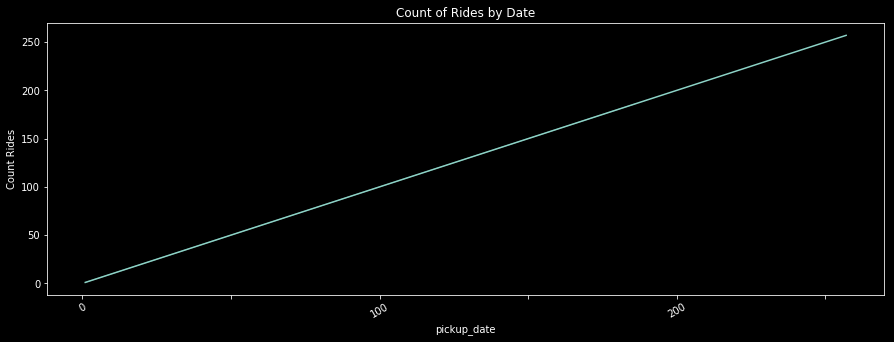

In [ ]:
fig, ax =plt.subplots(figsize=(15,5))
ax = sns.lineplot(ax=ax, x='pickup_date', y='fare_amount', data=year_count_df)
ax.set_title('Count of Rides by Date')
for i, item in enumerate(ax.get_xticklabels()): 
    item.set_rotation(30)
    if i % 2 == 0: item.set_visible(False)
plt.ylabel("Count Rides")
plt.show()

From 2009 to 2014, the data is relatively evenly distributed. We also notice that we don't have a full years worth of data in 2015. 

#### Fare throughout Time

In [ ]:
date_pivot = df.pivot_table(['fare_amount','fare_per_mile', 'distance_of_ride','congestion'], index='pickup_date', aggfunc=np.mean)
date_pivot = date_pivot.reset_index()

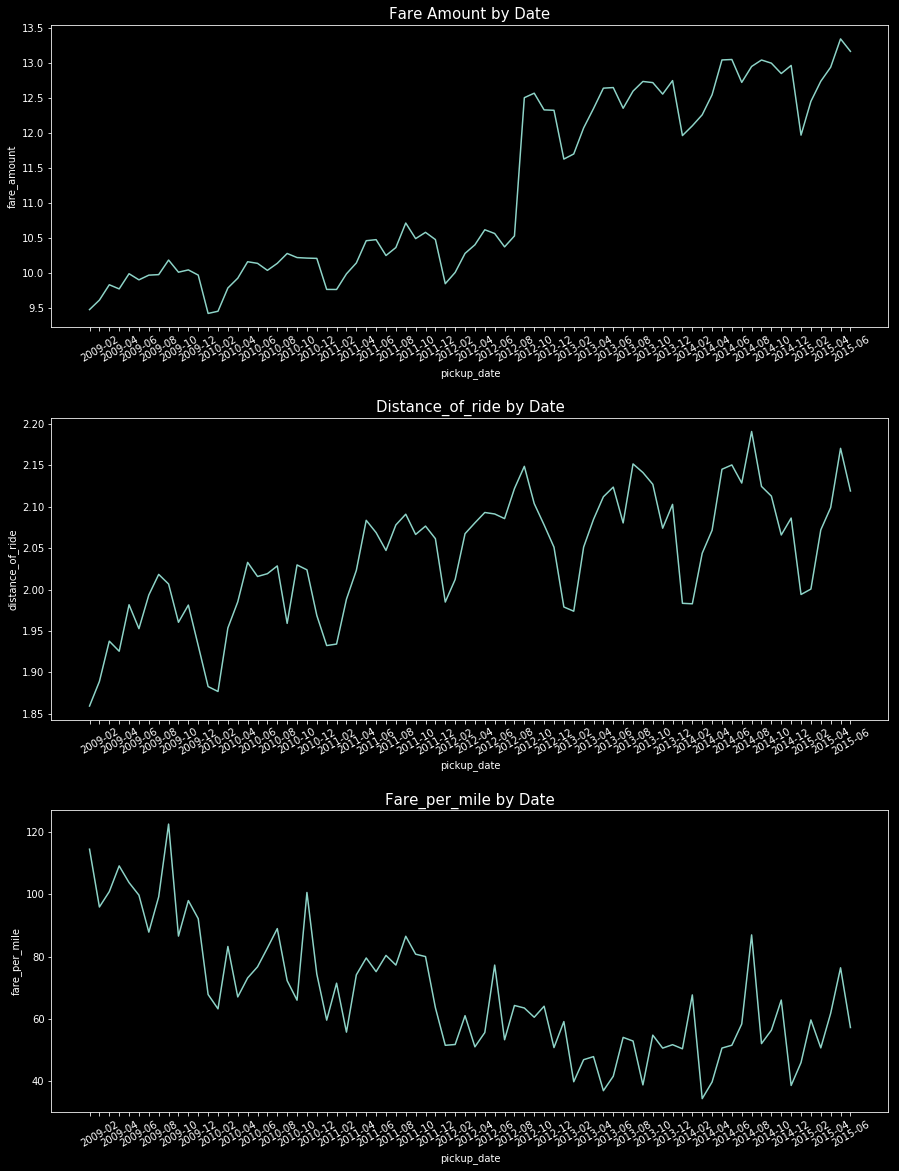

In [ ]:
fig, ax_all = plt.subplots(3,1, figsize=(15,20))
plt.subplots_adjust(hspace=0.3)

ax = sns.lineplot(ax=ax_all[0], x='pickup_date', y='fare_amount', data=date_pivot)
ax.set_title('Fare Amount by Date', size='15')
for i, item in enumerate(ax.get_xticklabels()): 
    item.set_rotation(30)
    if i % 2 == 0: item.set_visible(False)
    
ax2 = sns.lineplot(ax=ax_all[1], x='pickup_date', y='distance_of_ride', data=date_pivot)
ax2.set_title('Distance_of_ride by Date', size='15')
for i, item in enumerate(ax2.get_xticklabels()): 
    item.set_rotation(30)
    if i % 2 == 0: item.set_visible(False)
    
ax3 = sns.lineplot(ax=ax_all[2], x='pickup_date', y='fare_per_mile', data=date_pivot)
ax3.set_title('Fare_per_mile by Date', size='15')
for i, item in enumerate(ax3.get_xticklabels()): 
    item.set_rotation(30)
    if i % 2 == 0: item.set_visible(False)

In investigating why the average fare amount per month took such a huge increase in 2012, we found that in 2012, there was an increase of fare in airport rides between Manhattan and JFK airport, which went up by $7 (to its current rate at $52) and rides to Newark Airport, which went up by $2.50.

Text(0.5, 1.0, 'Congestion per year')

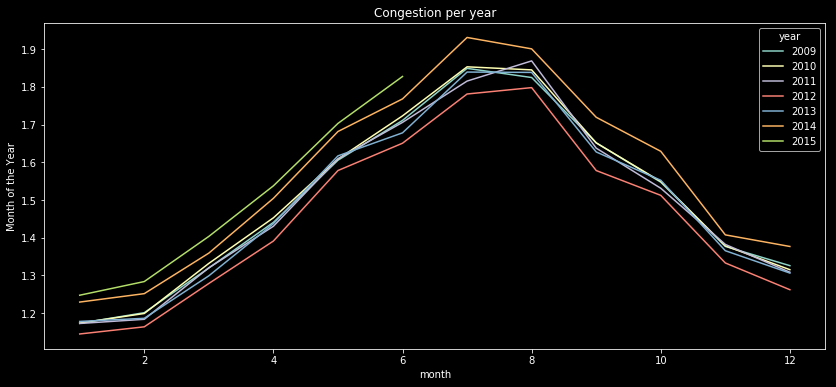

In [ ]:
df.pivot_table('congestion', index='month', columns='year').plot(figsize=(14,6))
plt.ylabel('Month of the Year')
plt.title('Congestion per year')

The seasonality of taxi activity is further depicted by the congestion feature, which shows that there is a clear peak in the summer period from oJuly to August, and a dip between the months December to january.

#### Fare per Mile

Text(0.5, 1.0, 'Fare/Mile per Hour of the day')

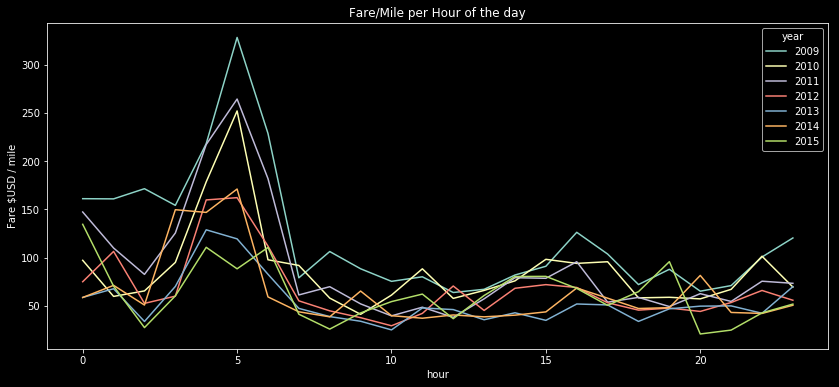

In [ ]:
df.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile')
plt.title('Fare/Mile per Hour of the day')

From the plot of fare by hour, we see that the most expensive taxi rides are at 5 AM and experiences a small increase around early afternoon after 15:00 PM.

Text(0.5, 1.0, 'Fare/Mile per Weekday')

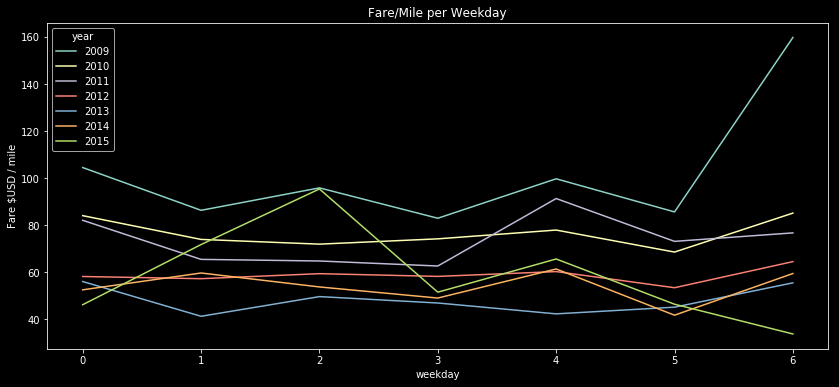

In [ ]:
df.pivot_table('fare_per_mile', index='weekday', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile')
plt.title('Fare/Mile per Weekday')

The graph above shows fare amount per mile by weekday. Monday is indexed as 0. Unfortunately we cannot discern a recognizable pattern in taxi fares per day of week.

#### Relationship between distance and fare

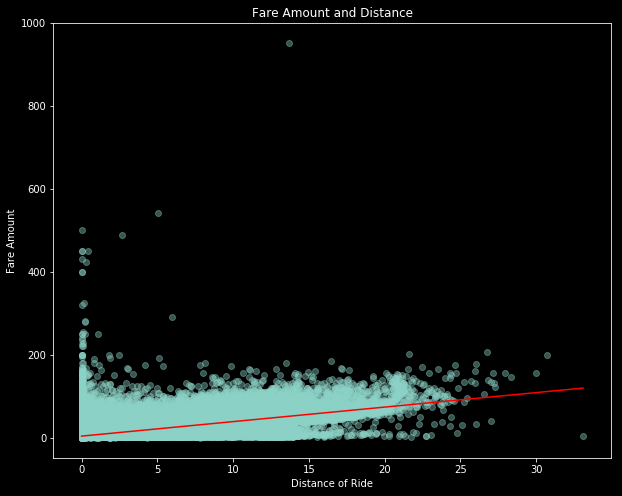

In [ ]:
# Simple linear regression predicting fare_amount with respect to distance
dist_x = df['distance_of_ride']
y = df['fare_amount']
results = sm.OLS(y,sm.add_constant(dist_x)).fit()
X_plot = np.linspace(0,max(dist_x),100)

plt.figure(figsize = (10,8))
plt.plot(X_plot, X_plot*results.params[0] + results.params[1], color = 'red')
plt.scatter(df.distance_of_ride, df.fare_amount, alpha=0.4)
plt.xlabel('Distance of Ride')
plt.ylabel('Fare Amount')
plt.title('Fare Amount and Distance')
plt.show()
# axs[0].set_title('All data')

As expected, we can see a positive relationship between distance and fare amount. The slope of the regression line is 3.758, which means every mile increase results in roughly a \\$3.75 increase in fare amount. According to the actual NYC fare calculation, since every 1/5 mile is \\$0.50, one mile should technically increment by \\$2.50, which is not too far off from our estimate.

[Text(0, 0.5, 'Fare Amount'), Text(0.5, 0, 'Airport Ride Type')]

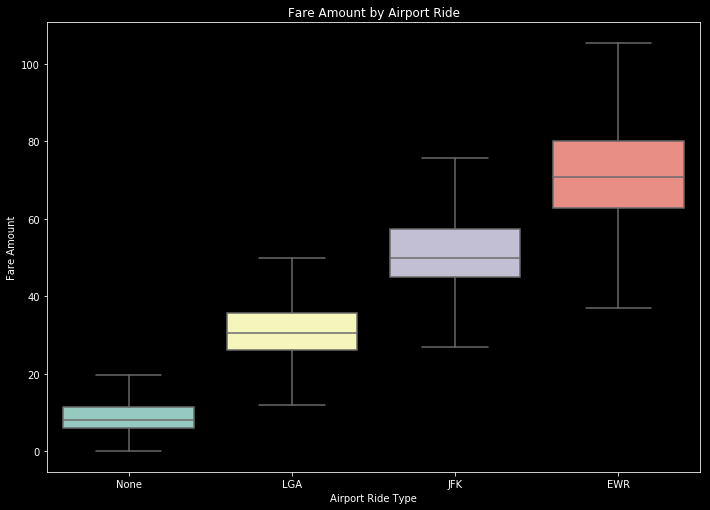

In [ ]:
#need to label NA values in airport type as none to be able to display in the bar graph
df.loc[df['airport_ride_type'].isna(),'airport_ride_type'] = 'None'

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
ax = sns.boxplot(data=df, x='airport_ride_type',y='fare_amount', showfliers=False)
ax.set_title('Fare Amount by Airport Ride')
ax.set(ylabel='Fare Amount', xlabel='Airport Ride Type')

We see from this graph that the mean fare for each airport ride type is different. JFK and EWR have a significant price surcharge, while LGA does not, but LGA rides still have a higher mean fare_amount probably because of the distance and because of the toll fee that needs to be paid in order to get there (It is outside of manhattan island and the toll for the bridge is \\$8.50).

## Split the Data

    For developing and comparing our three models, we will separate the Dataframe into three parts : Training Data, Validating Data and Testing Data.

In [ ]:
df = df.drop(['pickup_datetime', 'pickup_date'], axis=1)
df = pd.get_dummies(df)
x_train,x_test,y_train,y_test = train_test_split(df.loc[:, df.columns != 'fare_amount'],
                                                 df['fare_amount'],
                                                 random_state=0, test_size= 0.1)

## XG Boost

We will first use Extreme Gradient Boosting to try to predict taxi fares. XGBoost is a supervised learning algorithm that uses the features x_i of our data to predict a target variable y_i.

#### Prepare training and testing set

In [ ]:
# create DMatrix for XG boosting purposes
dtrain = xgb.DMatrix(x_train, y_train)

In [ ]:
x_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan,distance_of_ride,distance_pickup_jfk,distance_dropoff_jfk,distance_pickup_ewr,...,congestion,hour,month,year,weekday,fare_per_mile,airport_ride_type_EWR,airport_ride_type_JFK,airport_ride_type_LGA,airport_ride_type_None
3170964,-73.997795,40.736252,-73.979973,40.741577,2,True,1.002111,13.257734,12.660161,9.436328,...,0.981746,21,1,2013,1,6.985257,0,0,0,1
957245,-73.981972,40.775021,-73.976746,40.780113,1,True,0.445238,14.150985,14.184333,11.305445,...,2.246708,19,6,2012,3,15.497346,0,0,0,1
599549,-73.993858,40.721027,-73.943443,40.708946,1,False,2.767089,12.578178,9.853772,9.356337,...,1.423540,5,6,2010,5,4.661939,0,0,0,1
374356,-73.970444,40.759346,-73.996048,40.753578,5,True,1.397206,12.990768,13.821291,11.349923,...,1.368711,0,9,2011,5,5.224715,0,0,0,1
1061016,-73.949661,40.780888,-73.977028,40.748486,1,True,2.655867,13.224295,12.805632,12.979090,...,2.136880,17,5,2013,1,5.459611,0,0,0,1
733141,-73.955582,40.804298,-73.941780,40.798485,1,True,0.825577,14.649567,13.886004,13.555545,...,1.739198,8,4,2012,3,5.935247,0,0,0,1
4337200,-73.992149,40.730301,-73.990860,40.755779,1,True,1.760569,12.797891,13.687001,9.597077,...,1.522559,14,8,2011,3,6.418378,0,0,0,1
463188,-73.993652,40.741894,-73.988342,40.774620,1,True,2.276659,13.273314,14.385076,9.770481,...,1.335862,14,9,2012,5,4.831641,0,0,0,1
4749040,-73.981201,40.760246,-73.984924,40.768562,1,True,0.606266,13.468503,13.979867,10.864686,...,1.017496,22,2,2010,5,9.401820,0,0,0,1
3143291,-73.959953,40.776627,-73.957603,40.768478,1,True,0.575867,13.384983,12.904774,12.365775,...,1.747175,17,12,2011,1,8.508910,0,0,0,1


#### Define starting parameters

In [ ]:
params = {'max_depth': 5,
          'min_child_weight': 1,
          'eta': 0.1,
          'subsample': 0.8,
          'silent': 0,
          'nthread': 4,
          'eval_metric': 'rmse',
          'silent': 0,
          'objective': 'reg:linear'}

Method for tuning learned from: 

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a high learning rate and run the XGBooat algorithm with basic parameters. Find the optimum number of estimators at this learning rate.
    
2. Tune parameters max_depth and min_child_weight, which have the largest impact on the prediction qualtiy
    
3. Tune parameter eta (learning rate)

In [ ]:
# First pass at the parameters
cv_results = xgb.cv(params,
                    dtrain,
                    num_boost_round=1000,
                    nfold=10,
                    metrics={'rmse'},
                    early_stopping_rounds=10)
mean_rmse = cv_results['test-rmse-mean'].min()
print('mean test RMSE is {mse}'.format(mse=mean_rmse))

In [ ]:
print('Optimal number of trees found is {tree}. Update in parameter dictionary'.format(tree=cv_results.shape[0]))
params['n_estimators'] =  cv_results.shape[0]

In [ ]:
params

#### Tune max_depth and min_child_weight

In [ ]:
max_depth_list = [{'max_depth': e} for e in np.arange(3,20,4)]
min_child_weight_list = [{'min_child_weight': e} for e in np.arange(1,10,2)]
depth_child_combinations = [{**x, **y} for y in min_child_weight_list for x in max_depth_list]

In [ ]:
def tune_parameters(param_input_list, current_params):
    '''
    param_input_list: list of dictionaries with the various parameters that you want to try
    current_params: dictionary of the current state of the parameters
    returns: the element in the param_input_list that returned the lowest cross-validated RMSE
    '''
    min_rmse = float("Inf")
    for update_param in param_input_list:
        current_params.update(update_param)
        cv_results = xgb.cv(current_params,
                    dtrain,
                    num_boost_round=1000,
                    nfold=10,
                    metrics={'rmse'},
                    early_stopping_rounds=10)
        mean_rmse = cv_results['test-rmse-mean'].min()
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_input_param = update_param
    print('Best parameter set found is: ')
    print(best_input_param)
    print('Test MSE: {mse}'.format(mse=min_rmse))
    return best_input_param

In [ ]:
best_depth_combo = tune_parameters(depth_child_combinations, params)

In [ ]:
best_depth_combo

##### Further tune max_depth and min_child with smaller increments based on the first result

In [ ]:
current_best_max_depth = max(best_depth_combo['max_depth'],2)
current_best_min_child_weight = max(best_depth_combo['min_child_weight'],2)

max_depth_list_2 = [{'max_depth': e} for e in np.arange(current_best_max_depth-1,current_best_max_depth+1,1)]
min_child_weight_list_2 = [{'min_child_weight': e} for e in np.arange(current_best_min_child_weight-1,current_best_min_child_weight+1,1)]
depth_child_combinations_2 = depth_child_combinations = [{**x, **y} for y in min_child_weight_list_2 for x in max_depth_list_2]

print(depth_child_combinations_2)

In [ ]:
best_depth_combo_2 = tune_parameters(depth_child_combinations_2, params)

In [ ]:
# Finally, assign best combo to the parameter set
params['max_depth'] = best_depth_combo_2['max_depth']
params['min_child_weight'] = best_depth_combo_2['min_child_weight']

#### Tune eta

In [ ]:
eta_list = [{'eta': e} for e in np.arange(0.01, 0.3, 0.1)]
print(eta_list)

In [ ]:
best_eta = tune_parameters(eta_list, params)

In [ ]:
# Try more granular values of eta around the best_eta proposed
eta_list_2 = [{'eta': e} for e in np.arange(best_eta['eta']*0.7, best_eta['eta']*1.3, 0.03)]
print(eta_list_2)

In [ ]:
best_eta_2 = tune_parameters(eta_list_2, params)

In [ ]:
# Asssign best ETA to the new data
params['eta'] = best_eta_2['eta']

#### Check model accuracy

In [ ]:
# Get final model based on parameters found
matrix_train = xgb.DMatrix(x_train,label=y_train)
matrix_test = xgb.DMatrix(x_test,label=y_test)
model =xgb.train(params=params,
                dtrain=matrix_train,
                num_boost_round=5000,
                early_stopping_rounds=10,
                evals=[(matrix_test,'test')])

In [ ]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## K- Nearest Neigbours Regression

        The third method we will use is K-Nearest Neighbours. This is a non parametric method that relies on the patterns exctracted from our existing data. Since we have a great volume of data, it will be interesting to see how it performs.
        In this case, we will use KNN Regression, so we will have to assign weights to the nearest points and optimise for the best K.

In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 

In [ ]:
dscaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

params = [{'weights': ['uniform', 'distance'],
                     'p': [1,2]}]

knn = KNeighborsRegressor()

search = GridSearchCV(knn, params, 
                     scoring= 'neg_mean_squared_error',
                     iid=True, cv=5)
search.fit(x_train,y_train)
search.best_params_

In [ ]:
results['mean_test_score']

In [ ]:
search2 = GridSearchCV(KNeighborsRegressor(p=1, weights= 'distance'),
                  param_grid={'n_neighbors': range(2,20)},
                  scoring='neg_mean_squared_error', cv=5,
                  return_train_score=True)
search2.fit(x_train,y_train)
results = search2.cv_results_



plt.figure(figsize=(13, 13))
plt.title("GridSearchCV on MSE",
          fontsize=16)

plt.xlabel("Number of Neighbours")
plt.ylabel("Mean Square Error")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_neighbors'].data, dtype=float)

scorer= 'neg_mean_squared_error'
color= 'k'

for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = -results['mean_%s_score' % (sample)]
    sample_score_std = -results['std_%s_score' % (sample)]
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color=color)
    ax.plot(X_axis, sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s)" % (scorer, sample))

best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
best_score = -results['mean_test_score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.show()

In [ ]:
mse_val = [] #to store rmse values for different k
for K in range(2, 20):
    K = K+1
    kNN_model = KNeighborsRegressor(n_neighbors = K, p=1, weights='distance')

    kNN_model.fit(x_train, y_train)  #fit the model
    pred=kNN_model.predict(x_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    mse_val.append(error) #store rmse values
    
curve = pd.DataFrame(mse_val) #elbow curve 
curve.plot()

## Appendix

In [ ]:
# Traffic Congestion Statistics
IFrame(CNG_PATH, width=960, height=1000)

In [ ]:
# Seasonal Adjustment Factors
IFrame(SAF_PATH, width=960, height=1000)